# Сессия 3

##  3.1 Построение регрессионной модели

Для предсказания количества новых случаев заражения коронавирусныой инфекции в
различных странах на перспективу необходимо построить регрессионную модель. Итоговая
модель должна быть выбрана из нескольких построенных моделей на алгоритмах различной
степени сложности. Для получения оптимальной модели предсказания необходимо выбрать
метрику оценки качества работы моделей. 

#### Импортирование библиотек:

    

In [3]:
import pandas as pd
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

# Библиотеки для оценки метрик моделей
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Библиотеки для оценки стационарности временного ряда
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

import random
import datetime as dt

import warnings
warnings.filterwarnings(action="ignore")

Записываем dateframe, сразу устанавливаем признак даты как индекс, для обучения временного ряда.

In [4]:
df_date = pd.read_csv('result_1.csv', index_col = 'date', parse_dates = True)

In [3]:
df_date.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 364876 entries, 2020-01-10 to 2024-02-04
Data columns (total 31 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   location                         364876 non-null  object 
 1   total_cases                      364876 non-null  float64
 2   new_cases                        364876 non-null  float64
 3   new_cases_smoothed               364876 non-null  float64
 4   total_deaths                     364876 non-null  float64
 5   new_deaths                       364876 non-null  float64
 6   new_deaths_smoothed              364876 non-null  float64
 7   total_cases_per_million          364876 non-null  float64
 8   new_cases_per_million            364876 non-null  float64
 9   new_cases_smoothed_per_million   364876 non-null  float64
 10  total_deaths_per_million         364876 non-null  float64
 11  new_deaths_per_million           364876 non-null 

In [4]:
df_date.index

DatetimeIndex(['2020-01-10', '2020-01-11', '2020-01-12', '2020-01-13',
               '2020-01-14', '2020-01-15', '2020-01-16', '2020-01-17',
               '2020-01-18', '2020-01-19',
               ...
               '2024-01-26', '2024-01-27', '2024-01-28', '2024-01-29',
               '2024-01-30', '2024-01-31', '2024-02-01', '2024-02-02',
               '2024-02-03', '2024-02-04'],
              dtype='datetime64[ns]', name='date', length=364876, freq=None)

Датасет записался правильно, индекс - это дата, и тип соответсвующий.

Просмотрим значения первого дня записи.

In [5]:
df_date[df_date.index == '2020-01-10']

,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,human_development_index,population,month,year,RT,hazard_level
date,,,,,,,,,,,,,,,,,,,,,
2020-01-10,Afghanistan,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,...,6.300,33.100,37.7460,0.500,0.511,4.112877e+07,1,2020,0.0,безопасно
2020-01-10,Africa,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,...,6.300,33.100,49.6905,2.500,0.740,1.426737e+09,1,2020,0.0,безопасно
2020-01-10,Albania,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,...,7.100,51.200,49.6905,2.890,0.795,2.842318e+06,1,2020,0.0,безопасно
2020-01-10,Algeria,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,...,0.700,30.400,83.7410,1.900,0.748,4.490323e+07,1,2020,0.0,безопасно
2020-01-10,American Samoa,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,...,6.300,33.100,49.6905,2.500,0.740,4.429500e+04,1,2020,0.0,безопасно
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-10,Wallis and Futuna,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,...,6.300,33.100,49.6905,2.500,0.740,1.159600e+04,1,2020,0.0,безопасно
2020-01-10,World,2.0,0.0,0.286,3.0,0.0,0.429,0.0,0.0,0.0,...,6.434,34.635,60.1300,2.705,0.737,7.975105e+09,1,2020,0.0,безопасно
2020-01-10,Yemen,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,...,7.600,29.200,49.5420,0.700,0.470,3.369661e+07,1,2020,0.0,безопасно


Видим, что записей с индексом 2020-01-10  246. Так как нужно спрогнозировать новые случай заражения, то имеет смысл сложить новые случаи по датам, для дальнейшего прогнозирования.

Прогнозирование будем проводить по признаку new_cases_smoothed -  сглаженные случай заражения за 7 дней. Это нужно для того, чтобы случай заражения расположились равномерно, ведь в признаке new_cases не зафиксированы случаи за каждый день, наоборот, в понедельник проставлено число заражений за неделю, в остальные дни недели - нули.

In [6]:
df_date_gr = pd.DataFrame(df_date.groupby(df_date.index)['new_cases_smoothed'].sum())
df_date_gr

,new_cases_smoothed
date,
2020-01-10,1.287
2020-01-11,1.287
2020-01-12,25.716
2020-01-13,25.716
2020-01-14,25.716
...,...
2024-01-31,47094.860
2024-02-01,47094.860
2024-02-02,47094.860


In [7]:
df_date_gr['new_cases_smoothed'] = df_date_gr['new_cases_smoothed'].astype(int)
df_date_gr

,new_cases_smoothed
date,
2020-01-10,1
2020-01-11,1
2020-01-12,25
2020-01-13,25
2020-01-14,25
...,...
2024-01-31,47094
2024-02-01,47094
2024-02-02,47094


Итого имеется выборка из 1487 значений.

#### Обучающая и тестовая выборка

Возьмём для тестовой выборки даты начиная с 2023-го года, а для обучения - прошлые года.

In [8]:
# тестовая выборка начнется с января 2023 года (чуть больше года)
test = df_date_gr['2023-01-01':]
# обучающая выборка будет включать данные до декабря 2022 года включительно
train = df_date_gr.drop(index=df_date_gr.loc['2023-01-01':].index)

In [9]:
print(f'{test.shape} {train.shape}')

(400, 1) (1087, 1)


In [10]:
print(f'Процент отданный на тестовую часть: {len(test)*100/len(df_date_gr)}')

Процент отданный на тестовую часть: 26.899798251513115


Получился оптимальный процент для тестовой выборки.

### Анализ временных рядов

Просмотрим как распределено заражение начиная с 2020 года.

[Text(0.5, 1.0, 'Заражение ковидом'),
 Text(0.5, 0, 'Года'),
 Text(0, 0.5, 'Заражения')]

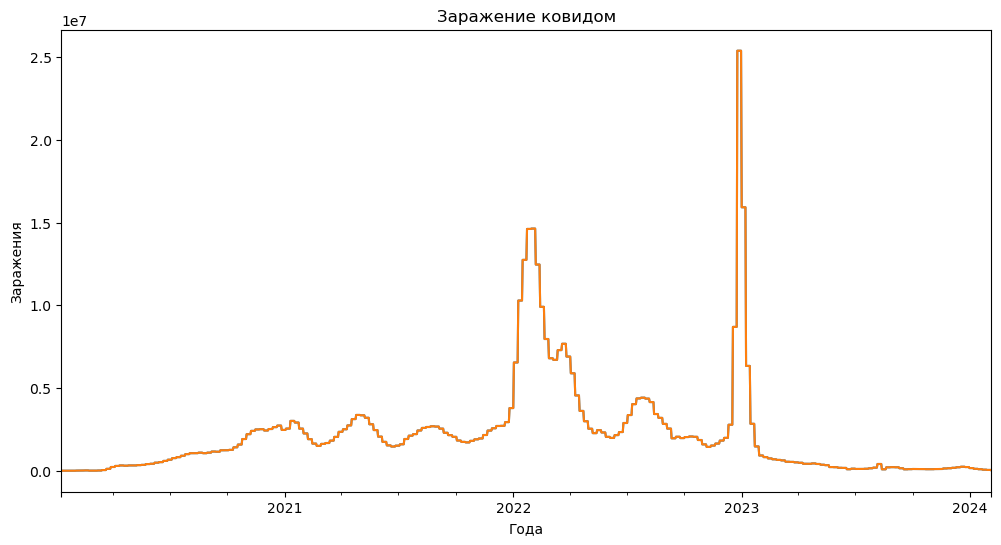

In [11]:
df_date_gr['new_cases_smoothed'].plot()
ax = df_date_gr['new_cases_smoothed'].plot(figsize = (12,6), legend = None)
ax.set(title = 'Заражение ковидом', xlabel = 'Года', ylabel = 'Заражения')


На графике видно, что есть большие скачки в январе 2022-го года, и в январе 2023-го года. Также можно заметить переодические скачки заражения с июля 2020 до 2022 января. В 2024м году случаи заражения близки к 0.

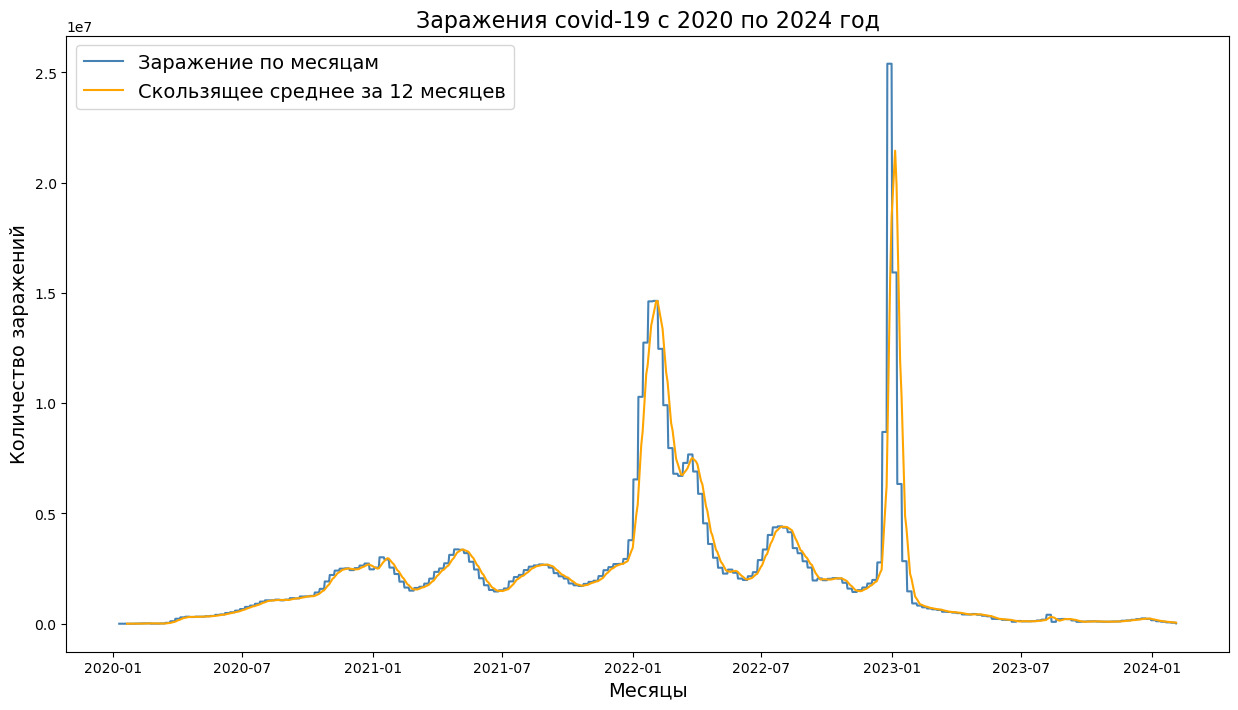

In [12]:
new_cases = (df_date_gr['new_cases_smoothed'])

# зададим размер графика
plt.figure(figsize = (15,8))
 
# поочередно зададим кривые (заражения и скользящее среднее) с подписями и цветом
plt.plot(new_cases, label = 'Заражение по месяцам', color = 'steelblue')
plt.plot(new_cases.rolling(window = 12).mean(), label = 'Скользящее среднее за 12 месяцев', color = 'orange')
 
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)
 
# добавим подписи к осям и заголовки
plt.xlabel('Месяцы', fontsize = 14)
plt.ylabel('Количество заражений', fontsize = 14)
plt.title('Заражения covid-19 с 2020 по 2024 год', fontsize = 16)
 
# выведем обе кривые на одном графике
plt.show()

Скользящее среднее мы взяли за 12 месяцев, оно несильно сгладило значения.

#### Стационарность данных

Тренд — долгосрочное изменение уровня ряда

Сезонность предполагает циклические изменения уровня ряда с постоянным периодо


Случайные колебания — непрогнозируемое случайное изменение ряда

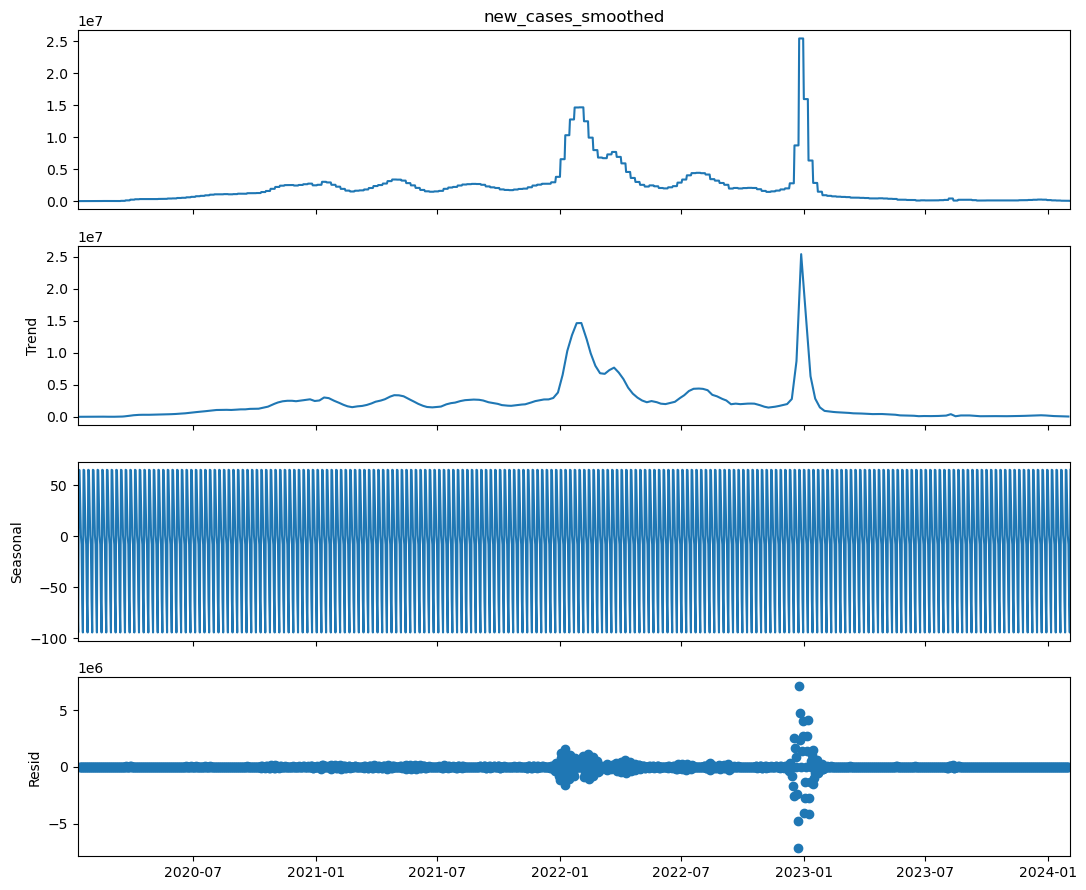

In [13]:
rcParams['figure.figsize'] = 11, 9
 
# применяем функцию к данным о перевозках
decompose = seasonal_decompose(new_cases)
decompose.plot()
 
plt.show()

Такое понятие как сезонность отсутвует, так как на графике можно увидеть, что число заражений не повторяется в определённый сезон года.

Тренд так же отсутствует, данные не стремятся ни к снижению, ни к увеличению.

Из этого можно сделать вывод, что ряд стационарен, проверим это тестом Дики-Фуллера.

In [14]:
# передадим ей столбец с данными о заражениях и поместим результат в adf_test
adf_test = adfuller(new_cases)
 
# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.001446049486045896


Результат существенно меньше 5%. Временной ряд стационарен.
Надо сказать, что наша визуальная оценка полностью совпала с математическими вычислениями.

<Figure size 1500x800 with 0 Axes>

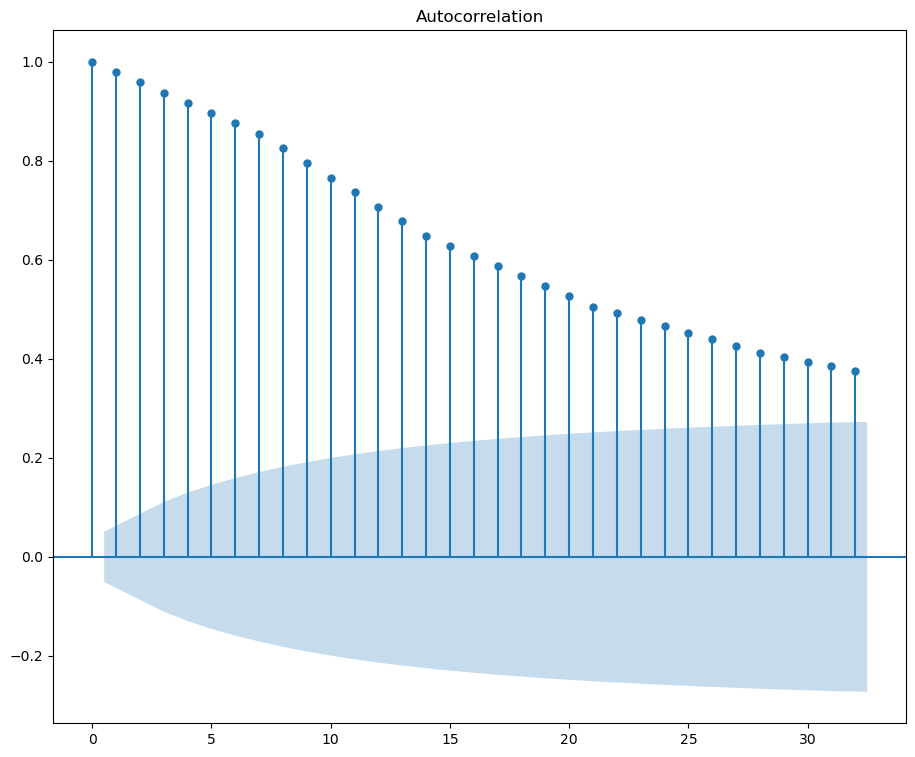

In [15]:
plt.figure(figsize = (15,8))

plot_acf(new_cases)
plt.axis('tight')
plt.show()

Автокорреляция позволяет выявлять тренд и сезонность, а также используется при подборе параметров моделей. В частности, мы видим, что первые лаги сильнее коррелирует с исходным рядом, чем последние. Такая автокорреляция позволяет предположить отсутствие (ежегодных) сезонных колебаний.

То, что корреляция постоянно положительная говорит о наличии трендаЭ этне о согласуется с тем, что мы узнали о данных, когда раскладывали их на компоненты.

Также замечу, что синяя граница позволяет оценить статистическую значимость корреляции. Если столбец выходит за ее пределы, то автокорреляция достаточно сильна и ее можно использовать при построении модмости.

### Обучение моделей

In [16]:
train = train['new_cases_smoothed']
test = test['new_cases_smoothed']

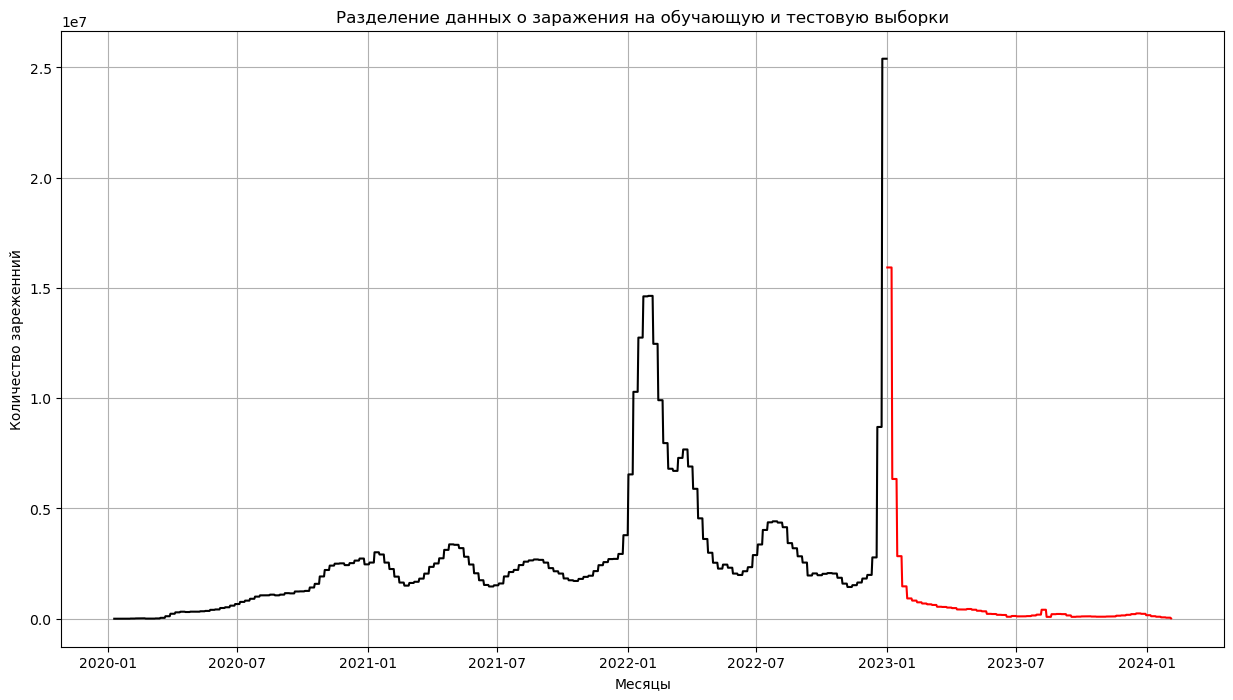

In [17]:
plt.figure(figsize = (15,8))
plt.plot(train, color = "black")
plt.plot(test, color = "red")
 
# заголовок и подписи к осям
plt.title('Разделение данных о заражения на обучающую и тестовую выборки')
plt.ylabel('Количество зареженний')
plt.xlabel('Месяцы')
 
# добавим сетку
plt.grid()
 
plt.show()

На графике видно, что мы прогнозируем красную линию на грфике. Используем три модели прогнозирования для временного ряда: SARIMAX, GARCH, KNeighborsRegressor.

### SARIMAX 

Используем модель SARIMAX для прогнозирования временных рядов. В ней присутствуют параметры, которые отвечают за тренд и сезонность.

In [18]:
model = SARIMAX(train, 
                order = (0, 0, 1), 
                seasonal_order = (0, 0, 1, 12))

result = model.fit()

In [19]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
 
# и закончится в конце тестового
end = len(train) + len(test) - 1
  
# применим метод predict
predictions = result.predict(start, end)

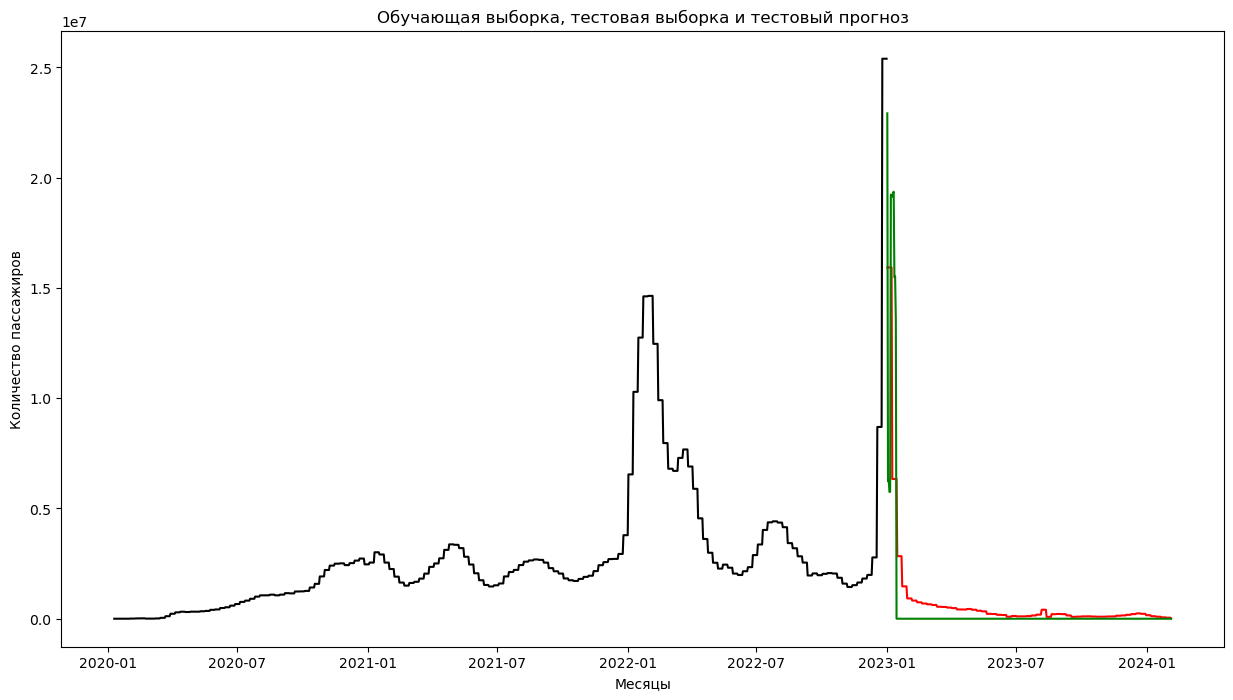

In [20]:
plt.figure(figsize = (15,8))

# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(predictions, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
 
plt.show()

Красная линия - тестовые данные, зелённые - предсказанные. Модель не предсказала переход со скачка до низкого заражения, сделав это слишком резко. Посмотрим метрики.

In [21]:
# рассчитаем MSE
print(mean_squared_error(test, predictions))
 
# и RMSE
print(np.sqrt(mean_squared_error(test, predictions)))

3356086329049.12
1831962.425665199


In [22]:
# Вычисление R-squared
r_squared = r2_score(test, predictions)
r_squared

0.31802140076744345

Большие значения ошибок, и маленькое значения r2_score. По метрикам модель предсказывает данные хуже среднего.

### GARCH

Модель garch также относится к моделям специальных для предсказания временного ряда. Она не имеет таких сложных парметров, как  sarimax.

Text(0.5, 1.0, 'Скользящее прогнозирование')

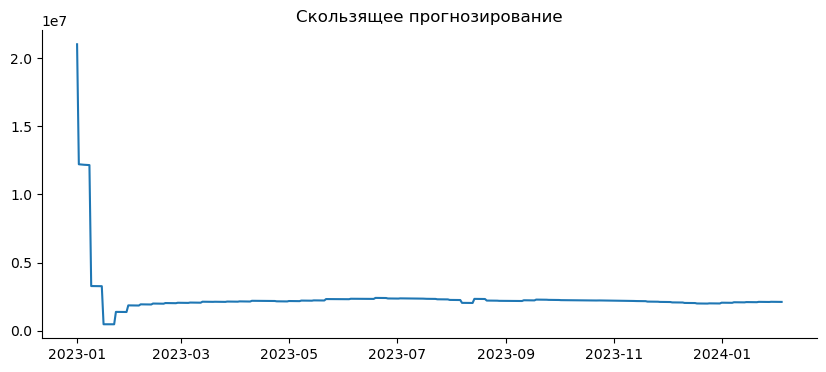

In [23]:
rolling_predictions = []
test_size = len(test)

# перебираем количество значений который нужно предсказать
for i in range(test_size):
    train_ = df_date_gr['new_cases_smoothed'][:-(test_size-i)]
    model = arch_model(train_, p=2, q=2,
                       mean = 'constant', vol = 'GARCH', dist = 'normal')
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=df_date_gr.index[-len(test):])


fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_predictions)
plt.title('Скользящее прогнозирование')

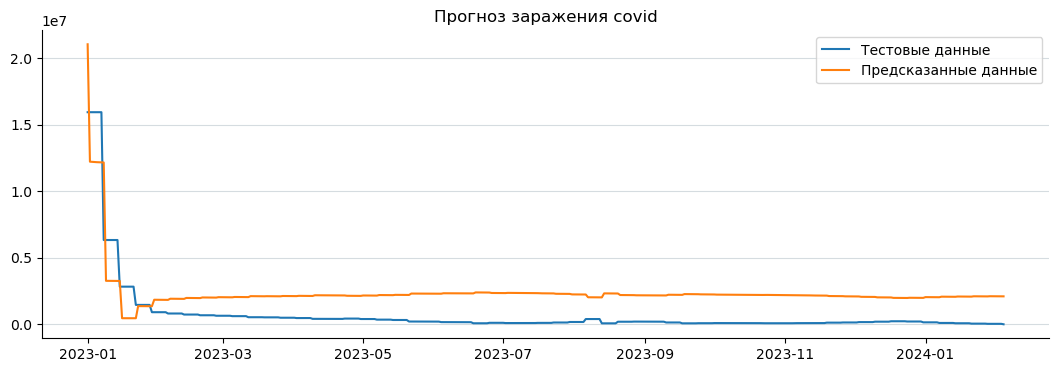

In [24]:
fig,ax = plt.subplots(figsize=(13,4))
ax.grid(which="major", axis='y', color='#758D99', alpha=0.3, zorder=1)
ax.spines[['top','right']].set_visible(False)
plt.plot(df_date_gr[-test_size:])
plt.plot(rolling_predictions)
plt.title('Прогноз заражения covid')
plt.legend(['Тестовые данные', 'Предсказанные данные'])

In [25]:
# импортируем метрику
from sklearn.metrics import mean_squared_error
 
# рассчитаем MSE
print(mean_squared_error(test, rolling_predictions))
 
# и RMSE
print(np.sqrt(mean_squared_error(test, rolling_predictions)))

4034284828444.717
2008552.9190053013


In [26]:
r_squared = r2_score(test, rolling_predictions)
r_squared

0.18020704878965155

Хоть оценки данной модели хуже прошлой, по графику видно, что предсказывает она в правильном направлении.

### KNeighborsRegressor

Регресионный метод ближайших соседей. Эта модель работает с разными данными, в том числе с временными рядами, но она не предназначена специально для них.

In [27]:
def k_nearest_neighbours_predict(df):
    shape=df.shape[0]
    df_new=df[['new_cases_smoothed']]
    df_new.head()
    train_set=df_new.drop(index=df_new.loc['2023-01-01':].index)
    valid_set=df_new['2023-01-01':]
    
    train_=train_set.reset_index()
    valid_=valid_set.reset_index()
    
    x_train = train_.index
    y_train = train_[['new_cases_smoothed']]
    x_valid = valid_.index
    y_valid = valid_[['new_cases_smoothed']]
    
    x_train_scaled = scaler.fit_transform(np.array(x_train).reshape(-1, 1))
    x_train = pd.DataFrame(x_train_scaled)
    x_valid_scaled = scaler.fit_transform(np.array(x_valid).reshape(-1, 1))
    x_valid = pd.DataFrame(x_valid_scaled)
    
    params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)
    model.fit(x_train,y_train)
    preds = model.predict(x_valid)
   
    valid_set['Predictions'] = preds

    plt.figure(figsize = (15,8))
    plt.plot(train_set[['new_cases_smoothed']])
    plt.plot(valid_set[['new_cases_smoothed', 'Predictions']])
    plt.xlabel('Месяц',size=20)
    plt.ylabel('Число заражений',size=20)
    plt.title('Предсказания заражения covid K-Nearest Neighbors',size=20)
    plt.legend(['Обучающие данные','Тестовые данные','Предсказанные данные'])
    plt.show()
    
    print('Оценка модели:')
    rms=(mean_squared_error(np.array(y_valid), np.array(preds)))
    print('MSE:',rms)
    rms=np.sqrt(mean_squared_error(np.array(y_valid), np.array(preds)))
    print('RMSE:',rms)
    r_squared = r2_score(y_valid, preds)
    print('r2 score:',r_squared)

    

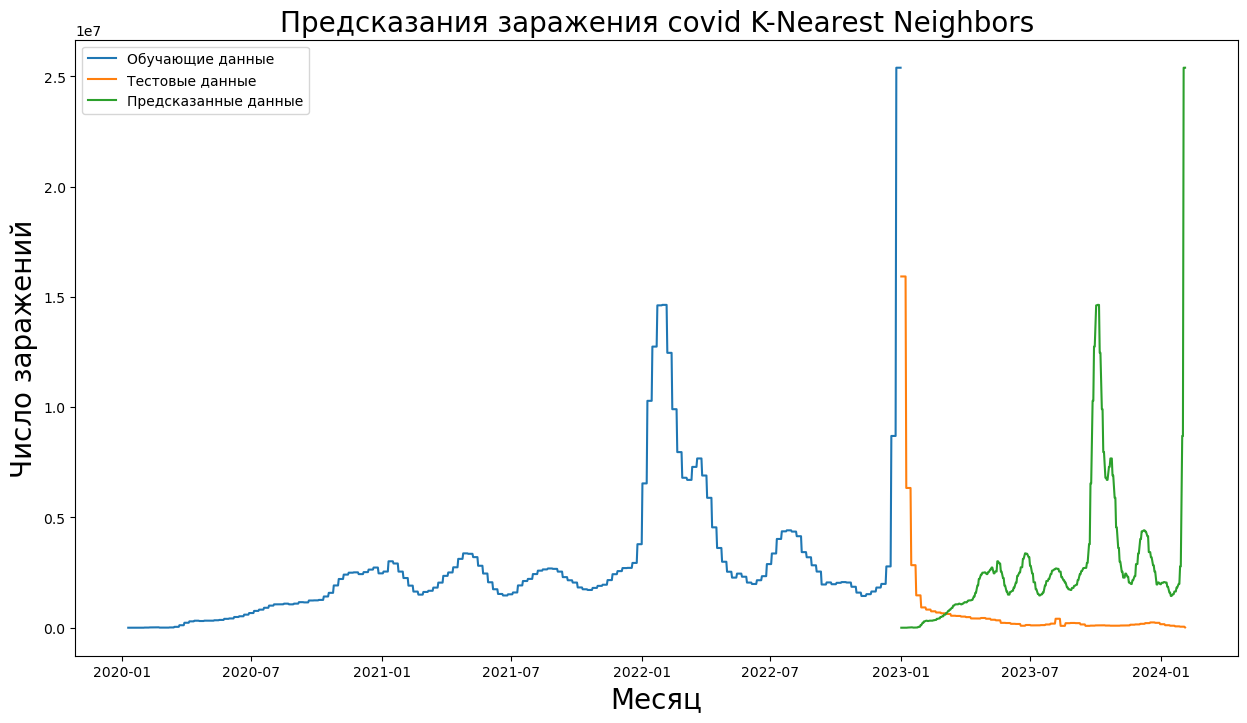

Оценка модели:
MSE: 22709377299618.49
RMSE: 4765435.688330973
r2 score: -3.6146933665515855


In [28]:
k_nearest_neighbours_predict(df_date_gr)

И по графику, и по метрикам видно, что модель не смогла предсказать данные верно. 

#### Вывод

Лучшей моделью по метрикам является sarimax, однако, если смотреть на графики, то можно сделать вывод, что данная модель не прогнозирует низкие значения. Модель garch оказалась хуже по метрикам, но по графику видно, что она хорошо предсказала направление заражения, хоть данные были чуть выше.

Из вышеперечисленного выше делаем вывод, что лучшей моделью для данного прогноза является garch.

## 3.2 Визуализация работы регрессионной модели
Визуализируйте предсказания, полученные в результате работы построенной регрессионной
модели для нескольких последующих месяцев, начиная с текущего. Визуализация должна
наглядно показывать прогнозируемое количество новых случаев заражения для различных
стран


### Предсказание

Для начала создадим новый фреим данных, куда запишем предсказанные значения на два месяца вперёд.

In [29]:
# создание фрейма данных для новых прогнозов
columns = ['date', 'location', 'new_cases']
df_cases = pd.DataFrame(columns=columns)
df_cases.set_index('date', inplace=True)

# перебираем локаций
for lok_i in set(df_date['location'].tolist()):
    df_loc = df_date[df_date['location'] == lok_i][['location', 'new_cases', 'new_cases_smoothed']]
    pred_size = 62
    
    # перебираем количество значений который нужно предсказать, обучаем модель и записываем предсказанные данные
    for i in range(pred_size):
        train_ = df_loc['new_cases_smoothed']
        model = arch_model(train_, p=1, q=1,
                           mean = 'constant', vol = 'GARCH', dist = 'normal')
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        df_loc.loc[df_loc.index[-1] + dt.timedelta(days=1)] = [lok_i, np.sqrt(pred.variance.values[-1,:][0]), np.sqrt(pred.variance.values[-1,:][0])]

    # записываем предсказанные значения в df_cases
    df_loc = df_loc[df_loc.index >= '2024-02-01']
    df_cases = pd.concat([df_cases, df_loc[['location', 'new_cases']]])


D:\User\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
D:\User\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
D:\User\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
D:\User\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
D:\User\anaconda3\Lib\site-pack

In [30]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15972 entries, 2024-02-01 to 2024-04-06
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   location   15972 non-null  object 
 1   new_cases  15972 non-null  float64
dtypes: float64(1), object(1)
memory usage: 374.3+ KB


In [31]:
len1 = len(set(df_date['location'].tolist()))
len2 = len(set(df_cases['location'].tolist()))
print(f'Количество локаций в исходном df: {len1} \nКоличество локаций в новом df: {len2}')

Количество локаций в исходном df: 246 
Количество локаций в новом df: 242


Данные были успешно записаны. Количество локаций одинаково как в новом df, так и в прошлом. Даты записались с 1-го февраля по начало апреля.

### Визуализация

Используя новый фреим данных, выведем графики заражения по дням на два месяца вперёд.

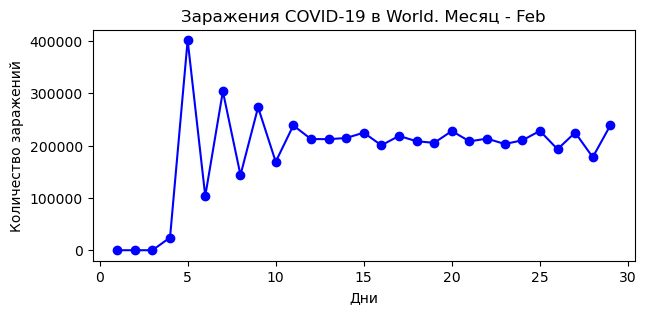

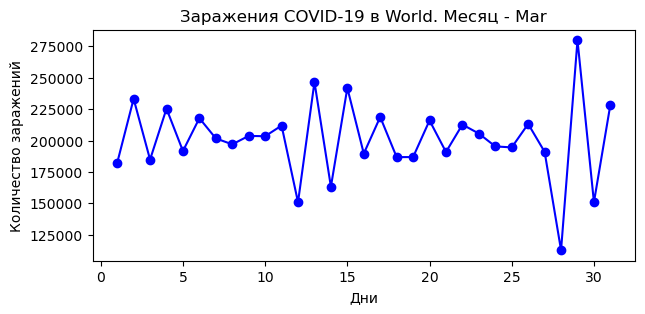

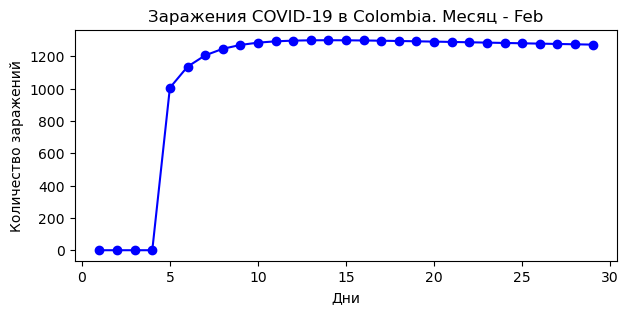

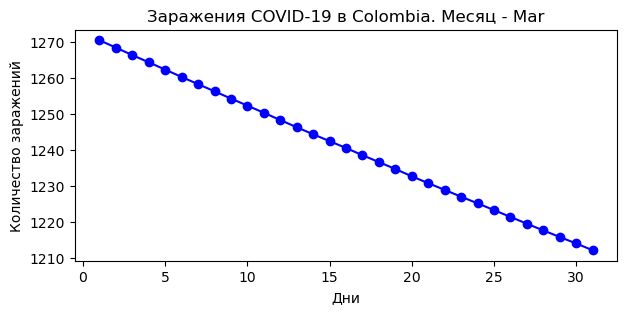

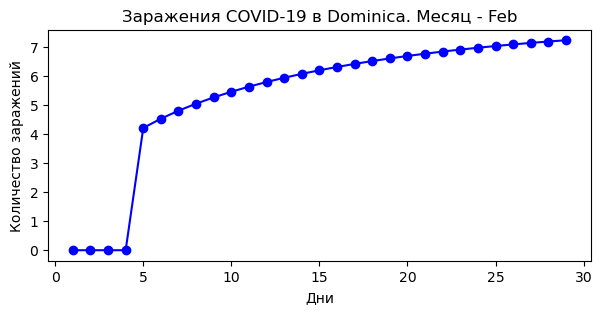

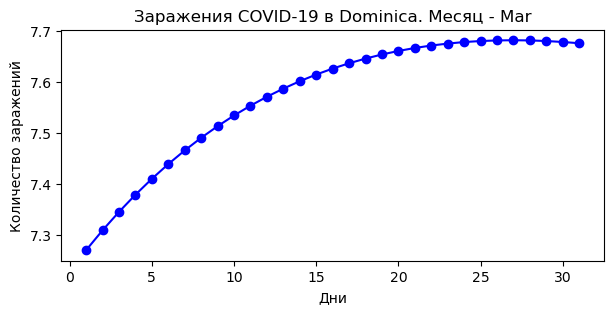

In [32]:
locations = list(set(df_cases['location'].tolist()))
random_loc = random.sample(locations, 3)

for i in random_loc:
    df_loc_1 = df_cases[(df_cases['location'] == i) & (df_cases.index.month == 2)]
    df_loc_2 = df_cases[(df_cases['location'] == i) & (df_cases.index.month == 3)]

    lst_df = (df_loc_1, df_loc_2)
    for df_i in lst_df:
        # Создание графика
        plt.figure(figsize=(7, 3))
        plt.plot(df_i.index.day, 
                 df_i['new_cases'], 
                 marker='o', color='b', linestyle='-')
        # Настройка графика
        plt.title(f'Заражения COVID-19 в {i}. Месяц - {df_i.iloc[1].name.strftime("%b")}')
        plt.xlabel('Дни')
        plt.ylabel('Количество заражений')
        plt.show()

In [13]:
df_date.iloc[:100]

,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,human_development_index,population,month,year,RT,hazard_level
date,,,,,,,,,,,,,,,,,,,,,
2020-01-10,Afghanistan,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.000,...,6.3,33.1,37.746,0.5,0.511,41128772.0,1,2020,0.0,безопасно
2020-01-11,Afghanistan,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.000,...,6.3,33.1,37.746,0.5,0.511,41128772.0,1,2020,0.0,безопасно
2020-01-12,Afghanistan,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.000,...,6.3,33.1,37.746,0.5,0.511,41128772.0,1,2020,0.0,безопасно
2020-01-13,Afghanistan,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.000,...,6.3,33.1,37.746,0.5,0.511,41128772.0,1,2020,0.0,безопасно
2020-01-14,Afghanistan,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.000,...,6.3,33.1,37.746,0.5,0.511,41128772.0,1,2020,0.0,безопасно
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-14,Afghanistan,521.0,0.0,35.286,15.0,0.0,1.429,12.668,0.0,0.858,...,6.3,33.1,37.746,0.5,0.511,41128772.0,4,2020,0.0,безопасно
2020-04-15,Afghanistan,521.0,0.0,35.286,15.0,0.0,1.429,12.668,0.0,0.858,...,6.3,33.1,37.746,0.5,0.511,41128772.0,4,2020,1.0,безопасно
2020-04-16,Afghanistan,521.0,0.0,35.286,15.0,0.0,1.429,12.668,0.0,0.858,...,6.3,33.1,37.746,0.5,0.511,41128772.0,4,2020,0.0,безопасно


In [10]:
def two_month_prediction(country_name):
    x = df_date[['location',
       'total_cases', 'new_cases', 'new_cases_smoothed',
       'total_deaths', 'new_deaths', 'new_deaths_smoothed',
        'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million',
        'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million',
        'new_vaccinations_smoothed', 'new_people_vaccinated_smoothed',
        'population_density', 'median_age', 'gdp_per_capita', 'extreme_poverty', 'female_smokers', 'male_smokers',
        'handwashing_facilities', 'hospital_beds_per_thousand', 'human_development_index', 'population', 'RT']]
    # x.set_index('date', inplace=True)
    # df_cases = pd.DataFrame(columns=columns)
    # df_cases.set_index('date', inplace=True)

    # берём локацию которую выбрал пользователь
    df_loc = x[x['location'] == country_name]
    pred_size = 120

    # перебираем количество значений который нужно предсказать, обучаем модель и записываем предсказанные данные
    for i in range(pred_size):
        # предсказание новых случаев
        train_cases = df_loc['new_cases_smoothed']
        model_cases = arch_model(train_cases, p=1, q=1,
                           mean='constant', vol='GARCH', dist='normal')
        model_fit_cases = model_cases.fit(disp='off')
        pred_cases = model_fit_cases.forecast(horizon=1)

        # предсказание новых смертей
        train_deaths = df_loc['new_deaths_smoothed']
        model_deaths = arch_model(train_deaths, p=1, q=1,
                           mean='constant', vol='GARCH', dist='normal')
        model_fit_deaths = model_deaths.fit(disp='off')
        pred_deaths = model_fit_deaths.forecast(horizon=1)

        # записываем новую запись в df
        last_date = df_loc.loc[df_loc.index[-1]]
        new_case = round(np.sqrt(pred_cases.variance.values[-1, :][0]))
        new_death = round(np.sqrt(pred_deaths.variance.values[-1, :][0]))
        total_cases = last_date['total_cases'] + new_case
        total_deaths = last_date['total_deaths'] + new_death
        population = last_date['population']

        # записываем новую запись в df, индекс это последняя дата плюс одна
        df_loc.loc[df_loc.index[-1] + dt.timedelta(days=1)] = [
            country_name,
            total_cases, new_case,  new_case,
            total_deaths, new_death, new_death,
            round(total_cases / (population / 1000000), 4), round(new_case / (population / 1000000), 4),
            round(new_case / (population / 1000000), 4),
            round(total_deaths / (population / 1000000), 4), round(new_death / (population / 1000000), 4),
            round(new_death / (population / 1000000), 4),
            last_date['new_vaccinations_smoothed'], last_date['new_people_vaccinated_smoothed'],
            last_date['population_density'], last_date['median_age'], last_date['gdp_per_capita'],
            last_date['extreme_poverty'], last_date['female_smokers'], last_date['male_smokers'],
            last_date['handwashing_facilities'], last_date['hospital_beds_per_thousand'],
            last_date['human_development_index'], population, last_date['RT']
        ]

        # записываем предсказанные значения в df_cases
        # df_loc = df_loc[df_loc.index >= '2024-02-01']

    x = x[x['location'] != country_name]
    x = pd.concat([x, df_loc])

    return x

In [11]:
two_month_prediction('Morocco')

D:\User\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
D:\User\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
D:\User\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
D:\User\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
D:\User\anaconda3\Li

,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,...,median_age,gdp_per_capita,extreme_poverty,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,human_development_index,population,RT
date,,,,,,,,,,,,,,,,,,,,,
2020-01-10,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,18.6,1803.987,2.5,6.3,33.1,37.7460,0.5,0.511,41128772.0,0.00
2020-01-11,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,18.6,1803.987,2.5,6.3,33.1,37.7460,0.5,0.511,41128772.0,0.00
2020-01-12,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,18.6,1803.987,2.5,6.3,33.1,37.7460,0.5,0.511,41128772.0,0.00
2020-01-13,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,18.6,1803.987,2.5,6.3,33.1,37.7460,0.5,0.511,41128772.0,0.00
2020-01-14,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,18.6,1803.987,2.5,6.3,33.1,37.7460,0.5,0.511,41128772.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30,Morocco,1279582.0,4.0,4.0,18956.0,26.0,26.0,34160.4683,0.1068,0.1068,...,29.6,7485.013,1.0,0.8,47.1,49.6905,1.1,0.686,37457976.0,1.07
2024-05-31,Morocco,1279586.0,4.0,4.0,18982.0,26.0,26.0,34160.5750,0.1068,0.1068,...,29.6,7485.013,1.0,0.8,47.1,49.6905,1.1,0.686,37457976.0,1.07
2024-06-01,Morocco,1279590.0,4.0,4.0,19008.0,26.0,26.0,34160.6818,0.1068,0.1068,...,29.6,7485.013,1.0,0.8,47.1,49.6905,1.1,0.686,37457976.0,1.07


Вывели 6 графиков, по два месяца на одну случайную локацию. Визуализация прошла успешно.

## 3.3 Подготовка отчета

Подготовьте отчет о проделанной работе по итогам сессии в котором будут представлены
результаты, выводы и обоснования выбора по каждому разделу задания. В отчете также
опишите содержимое результирующих файлов архива Data.zip

### Вывод

__3.1 Построение регрессионной модели__

Для прогнозирования временного ряда был проведён анализ данных, был сделан вывод, что данные заражения стационарны. После данного вывода были выбраны три регрессионные модели:

    Sarimax - модель показала не плохие результаты, на тестовой выборке, однако были выявлены скачки данных, которые помешали бы дальнейшему прогнозированию;
    Garch - модель лучше всех подошла для предсказания заражения covid-19, она правильно определила направление данных, хоть метрики имела хуже прошлой модели;
    KNeighborsRegressor - модель не подошла под данные заражения, показав самые худшие результаты.

В итоге была выбрана модель Garch.

__3.2 Визуализация работы регрессионной модели__

Было предсказано число заражений в каждой локаций из исходного набора данных, с помощью модели, выбранной в пункте 3.1. Так же была проведенна визуализация заражений на трёх разных локациях в феврале и марте.

__3.3 Подготовка отчета__

Был создан отчёт Report_3.html + Report_3.ipynb и файл Readme_3.txt содержащий информацию о данных, записали всё в Data_3.zip.